In [1]:
# !pip install yfinance
# !pip install yahoofinancials
# !pip install plotly==5.9.0
# !pip install category_encoders

###### Import libraries

In [2]:
from yahoofinancials import YahooFinancials
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr
import numpy as np
import seaborn as sns
import math

from sklearn.linear_model import LinearRegression, Ridge 
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer 
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

### Download and arrange the data.
** For now, for the code to work you need to download the differen stock prices at the same historical time 

- Download the historical Closing price of the stocks of interest
- create a smooth vartion of the Closing price of each stock by taking the avarage of 9 days, using the function: 
.rolling(9, min_periods=1, center=True).mean()
- Calculate the return of each stock at any given day after the coarse graining (smoothing the data)


In [3]:
start_date = '2013-01-12'
end_date ='2018-01-12'
list_of_stocks_names = ['SODA','KDP'] # pick 2 assets 
list_of_stocks_df = {}

In [4]:
for stock_name in list_of_stocks_names:
    stock_df = pd.DataFrame(yf.download(stock_name, 
                      start=start_date, 
                      end=end_date, 
                      progress=False,
                )['Close']) 
    stock_df['Smoothed_Close'] = stock_df['Close'].rolling(9, min_periods=1, center=True).mean()
    stock_df['Return'] = (stock_df['Smoothed_Close']/stock_df['Smoothed_Close'].shift(1)) -1
    stock_df.dropna(inplace=True)
    stock_df.name = stock_name
    
    list_of_stocks_df[stock_name]= stock_df

In [5]:
decreasing_asset_df = list_of_stocks_df[list(list_of_stocks_df.keys())[1]]
increasing_asset_df = list_of_stocks_df[list(list_of_stocks_df.keys())[0]]

## Algorithms and functions

### 1) find the downwards trend of an asset


In [6]:
''' 
Input: 
    list_i_down_trend - a list to save all the dates of initial times of decreasing trend; usually empty list.
    list_f_down_trend - a list to save all the final times of decreasing trend; usually empty list.
    
    
    asset - the stock DataFrame that we have.
    starting_time - the time that we start looking for downward trend.
    jump - how fast we scan the data; default = 1day.
    return_treshhold - the threshold value of negative return such that below that we accept a **sharp** deacreasing trend.
    
    
Output:
    list_i_down_trend = list of initial times of decreasing trend.
    list_f_down_trend = list of final times of decreasing trend.
'''
def find_downards_trend(list_i_down_trend, list_f_down_trend,
                        asset, starting_time, return_treshhold=-0.005, jump = 1):
    if starting_time > len(asset)-1:
        return list_i_down_trend,list_f_down_trend
    
    while asset['Return'].iloc[starting_time] > return_treshhold and starting_time + jump < len(asset)-1:
        starting_time = starting_time + jump
    
    count = 0
    while asset['Return'].iloc[starting_time + count+ jump] < 0 and starting_time + count+ jump < len(asset)-1:
        count += 1
    
    i_down_trend = starting_time
    f_down_trend = starting_time + count
    if count>5:      # At least 5 days of deacreasing trend
        list_i_down_trend.append(i_down_trend)
        list_f_down_trend.append(f_down_trend)
    if f_down_trend + 20 < len(asset)-1:
        find_downards_trend(list_i_down_trend, list_f_down_trend, asset, f_down_trend + 20, return_treshhold, jump)
    else:
        return [list_i_down_trend,list_f_down_trend]

In [7]:
list_i_down_trend=[]
list_f_down_trend=[]
find_downards_trend(list_i_down_trend, list_f_down_trend, decreasing_asset_df, 2)

We can plot the asset and the decreasing trend that we found

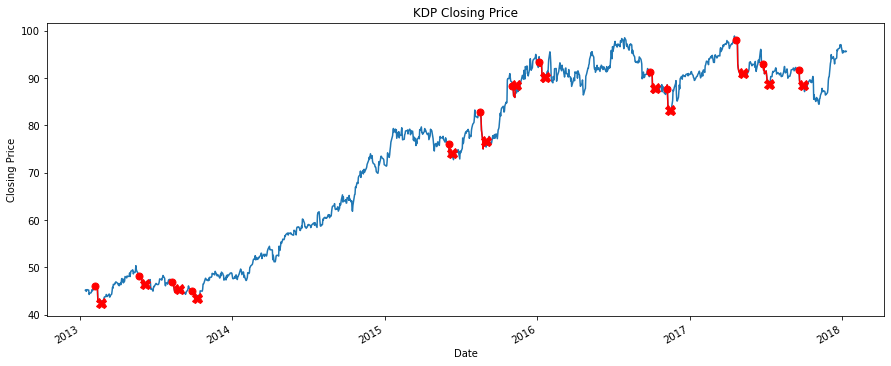

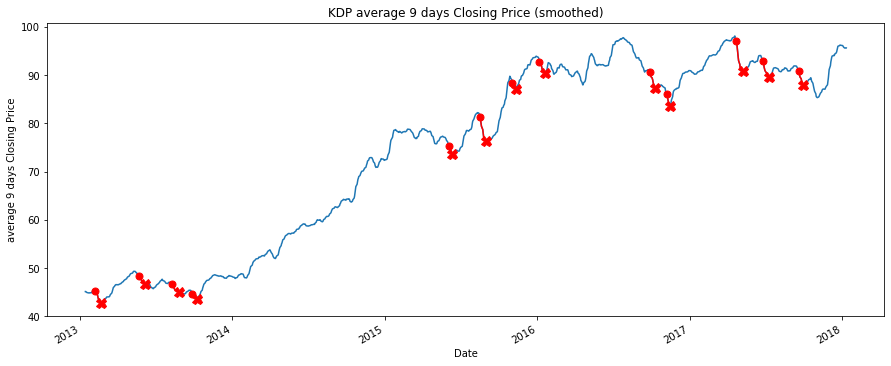

In [8]:

fig, ax = plt.subplots(figsize=(15, 6))
decreasing_asset_df['Close'].plot(
    title = f"{decreasing_asset_df.name} Closing Price",
    ax=ax
);

for i in range(len(list_i_down_trend)):

    decreasing_asset_df['Close'].iloc[list_i_down_trend[i] : list_f_down_trend[i]].plot(
        title = f"{decreasing_asset_df.name} Closing Price",
        ax=ax,
        color="r"
    );
    plt.xlabel("Date")
    plt.ylabel("Closing Price")
    plt.plot([decreasing_asset_df.index[list_i_down_trend[i]]], [decreasing_asset_df.iloc[list_i_down_trend[i]]['Close']], marker='o', markersize=7, color="red")
    plt.plot([decreasing_asset_df.index[list_f_down_trend[i]]], [decreasing_asset_df.iloc[list_f_down_trend[i]]['Close']], marker='X', markersize=10, color="red")

plt.show();



fig2, ax2 = plt.subplots(figsize=(15, 6))
decreasing_asset_df['Smoothed_Close'].plot(
    title = f"{decreasing_asset_df.name} average 9 days Closing Price (smoothed)",
    ax=ax2
);

for i in range(len(list_i_down_trend)):

    decreasing_asset_df['Smoothed_Close'].iloc[list_i_down_trend[i] : list_f_down_trend[i]].plot(
        title = f"{decreasing_asset_df.name} average 9 days Closing Price (smoothed)",
        ax=ax2,
        color="r"
    );
    plt.xlabel("Date")
    plt.ylabel("average 9 days Closing Price")
    plt.plot([decreasing_asset_df.index[list_i_down_trend[i]]], [decreasing_asset_df.iloc[list_i_down_trend[i]]['Smoothed_Close']], marker='o', markersize=7, color="red")
    plt.plot([decreasing_asset_df.index[list_f_down_trend[i]]], [decreasing_asset_df.iloc[list_f_down_trend[i]]['Smoothed_Close']], marker='X', markersize=10, color="red")

plt.show();

### 2A) Find the **time** when uprising trend happend *BEFORE* the other stock started to decrease

In [9]:
"""
Input:
    list_i_up_trend_before = a list to save all the dates of initial time of increasing trend
    list_f_up_trend_before = a list to save all the dates of final time of increasing trend

    asset1_dec - the stock DataFrame that we saw a decreasing trend
    asset2_inc - another stock that should increase before asset1 started its decreasing period
    i_down_trend = initial time of decreasing trend
    f_down_trend = final time of decreasing trend
    max_jump_back = the max amount of days we are looking back in time, before the initial time of decreasing trend; default = 30 days
    days_before = the min amount of days we are looking back in time, before the initial time of decreasing trend; default = 1 day
    
Output:
    list_i_up_trend_before = list of initial time of increasing trend
    list_f_up_trend_before = list of final time of increasing trend
    list_of_corr = list of correlations between the uprising in one asset and the downfall in the othe asset
"""

def find_increasing_trend_before(list_i_up_trend_before, list_f_up_trend_before, list_of_corr,
                                 asset1_dec, asset2_inc, 
                                 i_down_trend, f_down_trend, 
                                 max_jump_back=20, days_before=3):
    
    if f_down_trend > len(asset2_inc)-1:
        return 
    
    jump = 0
    delta_t = f_down_trend - i_down_trend
    
    f_up_trend_before_temp = i_down_trend -days_before
    i_up_trend_before_temp = f_up_trend_before_temp - delta_t
    
    corr_pear = pearsonr(asset1_dec.iloc[i_down_trend:f_down_trend]['Smoothed_Close'], asset2_inc.iloc[i_up_trend_before_temp-jump:f_up_trend_before_temp-jump]['Smoothed_Close'])[0]
    i_up_trend_before = i_up_trend_before_temp-jump
    f_up_trend_before = f_up_trend_before_temp-jump
    while i_up_trend_before_temp-jump > 0 and jump < max_jump_back:
        jump += 1
        if pearsonr(asset1_dec.iloc[i_down_trend:f_down_trend]['Smoothed_Close'], asset2_inc.iloc[i_up_trend_before_temp-jump:f_up_trend_before_temp-jump]['Smoothed_Close'])[0] < corr_pear:
                corr_pear = pearsonr(asset1_dec.iloc[i_down_trend:f_down_trend]['Smoothed_Close'], asset2_inc.iloc[i_up_trend_before_temp-jump:f_up_trend_before_temp-jump]['Smoothed_Close'])[0]
                i_up_trend_before = i_up_trend_before_temp-jump
                f_up_trend_before = f_up_trend_before_temp-jump
    
    list_i_up_trend_before.append(i_up_trend_before)
    list_f_up_trend_before.append(f_up_trend_before)
    list_of_corr.append(corr_pear)





def find_increasing_trend_before_list(list_i_up_trend_before, list_f_up_trend_before, list_of_corr,
                                 asset1_dec, asset2_inc, 
                                 list_i_down_trend, list_f_down_trend,
                                 max_jump_back=20,days_before=3):
    
    
    for i in range(len(list_i_down_trend)):
        
        find_increasing_trend_before(list_i_up_trend_before, list_f_up_trend_before, list_of_corr,
                                 asset1_dec, asset2_inc, 
                                 list_i_down_trend[i], list_f_down_trend[i], 
                                 max_jump_back=20, days_before=3)
        
        
        


In [10]:
list_i_up_trend_before=[]
list_f_up_trend_before=[]
list_of_corr = []
find_increasing_trend_before_list(list_i_up_trend_before, list_f_up_trend_before, list_of_corr,
                                 list_of_stocks_df[decreasing_asset_df.name], list_of_stocks_df[increasing_asset_df.name], 
                                 list_i_down_trend, list_f_down_trend,
                                 max_jump_back=120,days_before=3)

We can plot the asset of the increasing trend (**BEFORE** decreasing trend) that we found

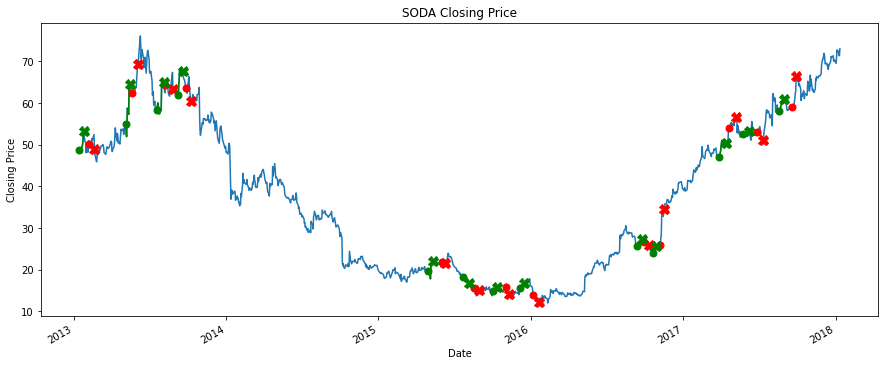

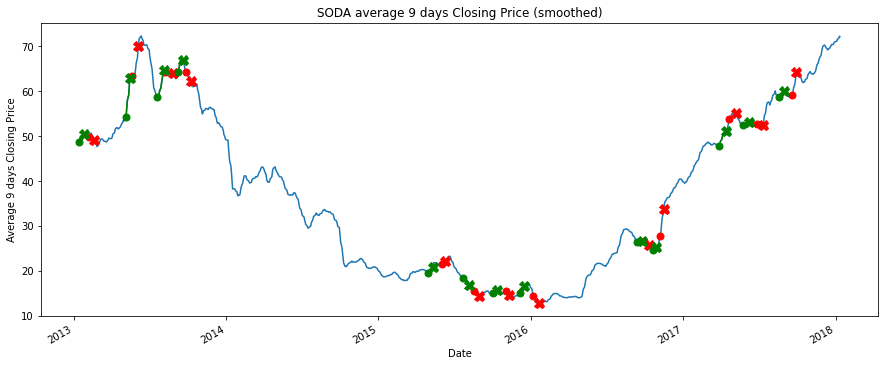

In [11]:

fig, ax = plt.subplots(figsize=(15, 6))
increasing_asset_df['Close'].plot(
    title = f"{increasing_asset_df.name} Closing Price",
    ax=ax
);

for i in range(len(list_f_up_trend_before)):

    increasing_asset_df['Close'].iloc[list_i_up_trend_before[i] : list_f_up_trend_before[i]].plot(
        title = f"{increasing_asset_df.name} Closing Price",
        ax=ax,
        color="g"
    );
    plt.xlabel("Date")
    plt.ylabel("Closing Price")
    plt.plot([increasing_asset_df.index[list_i_down_trend[i]]], [increasing_asset_df.iloc[list_i_down_trend[i]]['Close']], marker='o', markersize=7, color="red")
    plt.plot([increasing_asset_df.index[list_f_down_trend[i]]], [increasing_asset_df.iloc[list_f_down_trend[i]]['Close']], marker='X', markersize=10, color="red")
    plt.plot([increasing_asset_df.index[list_i_up_trend_before[i]]], [increasing_asset_df.iloc[list_i_up_trend_before[i]]['Close']], marker='o', markersize=7, color="green")
    plt.plot([increasing_asset_df.index[list_f_up_trend_before[i]]], [increasing_asset_df.iloc[list_f_up_trend_before[i]]['Close']], marker='X', markersize=10, color="green")

plt.show();



fig2, ax2 = plt.subplots(figsize=(15, 6))
increasing_asset_df['Smoothed_Close'].plot(
    title = f"{increasing_asset_df.name} average 9 days Closing Price (smoothed)",
    ax=ax2
);
for i in range(len(list_f_up_trend_before)):

    increasing_asset_df['Smoothed_Close'].iloc[list_i_up_trend_before[i] : list_f_up_trend_before[i]].plot(
        title = f"{increasing_asset_df.name} average 9 days Closing Price (smoothed)",
        ax=ax2,
        color="g"
    );
    plt.xlabel("Date")
    plt.ylabel("Average 9 days Closing Price")
    plt.plot([increasing_asset_df.index[list_i_down_trend[i]]], [increasing_asset_df.iloc[list_i_down_trend[i]]['Smoothed_Close']], marker='o', markersize=7, color="red")
    plt.plot([increasing_asset_df.index[list_f_down_trend[i]]], [increasing_asset_df.iloc[list_f_down_trend[i]]['Smoothed_Close']], marker='X', markersize=10, color="red")
    plt.plot([increasing_asset_df.index[list_i_up_trend_before[i]]], [increasing_asset_df.iloc[list_i_up_trend_before[i]]['Smoothed_Close']], marker='o', markersize=7, color="green")
    plt.plot([increasing_asset_df.index[list_f_up_trend_before[i]]], [increasing_asset_df.iloc[list_f_up_trend_before[i]]['Smoothed_Close']], marker='X', markersize=10, color="green")

plt.show();

### 2B) Find the **time** when uprising trend happend *AFTER* the other stock started to decrease

In [12]:
"""
Input:
    list_i_up_trend_after = a list to save all the dates of initial time of increasing trend
    list_f_up_trend_bafter = a list to save all the dates of final time of increasing trend

    asset1_dec - the stock DataFrame that we saw a decreasing trend
    asset2_inc - another stock that should increase AFTER asset1 started its decreasing period
    i_down_trend = initial time of decreasing trend
    f_down_trend = final time of decreasing trend
    max_jump_forward = the max amount of days we are looking forward in time, after the initial time of decreasing trend; default = 30 days
    days_after = the min amount of days we are looking forward in time, after the initial time of decreasing trend; default = 1 day
    
Output:
    list_i_up_trend_before = list of initial time of increasing trend
    list_f_up_trend_before = list of final time of increasing trend
    list_of_corr = list of correlations between the uprising in one asset and the downfall in the othe asset
"""

def find_increasing_trend_after(list_i_up_trend_after, list_f_up_trend_after, list_of_corr,
                                 asset1_dec, asset2_inc, 
                                 i_down_trend, f_down_trend, 
                                 max_jump_forward=30, days_after=1):
    
    if f_down_trend + max_jump_forward > len(asset2_inc)-4:
        return 
    
    jump = 0
    delta_t = f_down_trend - i_down_trend
    
    i_up_trend_after_temp = f_down_trend+days_after
    f_up_trend_after_temp = i_up_trend_after_temp+delta_t

    
    corr_pear = pearsonr(asset1_dec.iloc[i_down_trend:f_down_trend]['Smoothed_Close'], asset2_inc.iloc[i_up_trend_after_temp+jump:f_up_trend_after_temp+jump]['Smoothed_Close'])[0]
    i_up_trend_after = i_up_trend_after_temp+jump
    f_up_trend_after = f_up_trend_after_temp+jump
    while f_up_trend_after_temp+jump < len(asset2_inc)-4 and jump < max_jump_forward:
        jump += 1
        if pearsonr(asset1_dec.iloc[i_down_trend:f_down_trend]['Smoothed_Close'], asset2_inc.iloc[i_up_trend_after_temp+jump:f_up_trend_after_temp+jump]['Smoothed_Close'])[0] < corr_pear:
                corr_pear = pearsonr(asset1_dec.iloc[i_down_trend:f_down_trend]['Smoothed_Close'], asset2_inc.iloc[i_up_trend_after_temp+jump:f_up_trend_after_temp+jump]['Smoothed_Close'])[0]
                i_up_trend_after = i_up_trend_after_temp+jump
                f_up_trend_after = f_up_trend_after_temp+jump
    
    list_i_up_trend_after.append(i_up_trend_after)
    list_f_up_trend_after.append(f_up_trend_after)
    list_of_corr.append(corr_pear)





def find_increasing_trend_after_list(list_i_up_trend_after, list_f_up_trend_after, list_of_corr,
                                 asset1_dec, asset2_inc, 
                                 list_i_down_trend, list_f_down_trend,
                                 max_jump_forward=30,days_after=1):
    
    
    for i in range(len(list_i_down_trend)):
        
        find_increasing_trend_after(list_i_up_trend_after, list_f_up_trend_after, list_of_corr,
                                 asset1_dec, asset2_inc, 
                                 list_i_down_trend[i], list_f_down_trend[i], 
                                 max_jump_forward=30, days_after=1)
        
        
        

In [13]:
list_i_up_trend_after=[]
list_f_up_trend_after=[]
list_of_corr_after = []
find_increasing_trend_after_list(list_i_up_trend_after, list_f_up_trend_after, list_of_corr_after,
                                 list_of_stocks_df[decreasing_asset_df.name], list_of_stocks_df[increasing_asset_df.name], 
                                 list_i_down_trend, list_f_down_trend,
                                 max_jump_forward=120,days_after=3)

We can plot the asset of the increasing trend (**AFTER** decreasing trend) that we found

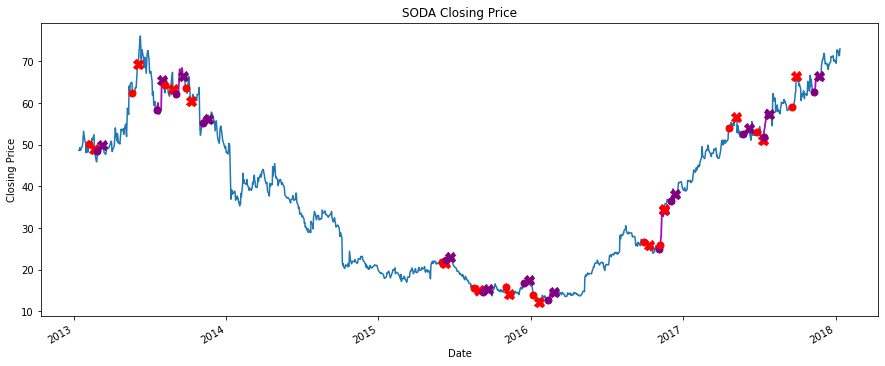

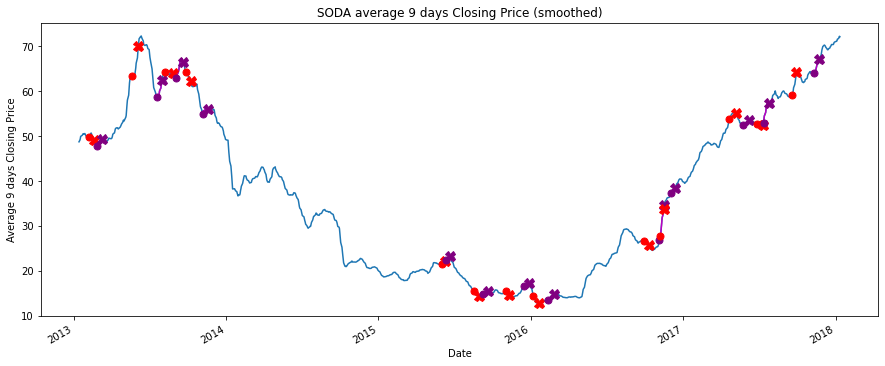

In [14]:

fig, ax = plt.subplots(figsize=(15, 6))
increasing_asset_df['Close'].plot(
    title = f"{increasing_asset_df.name} Closing Price",
    ax=ax
);

for i in range(len(list_f_up_trend_after)):

    increasing_asset_df['Close'].iloc[list_i_up_trend_after[i] : list_f_up_trend_after[i]].plot(
        title = f"{increasing_asset_df.name} Closing Price",
        ax=ax,
        color="m"
    );
    plt.xlabel("Date")
    plt.ylabel("Closing Price")
    plt.plot([increasing_asset_df.index[list_i_down_trend[i]]], [increasing_asset_df.iloc[list_i_down_trend[i]]['Close']], marker='o', markersize=7, color="red")
    plt.plot([increasing_asset_df.index[list_f_down_trend[i]]], [increasing_asset_df.iloc[list_f_down_trend[i]]['Close']], marker='X', markersize=10, color="red")
    plt.plot([increasing_asset_df.index[list_i_up_trend_after[i]]], [increasing_asset_df.iloc[list_i_up_trend_after[i]]['Close']], marker='o', markersize=7, color="purple")
    plt.plot([increasing_asset_df.index[list_f_up_trend_after[i]]], [increasing_asset_df.iloc[list_f_up_trend_after[i]]['Close']], marker='X', markersize=10, color="purple")

plt.show();



fig2, ax2 = plt.subplots(figsize=(15, 6))
increasing_asset_df['Smoothed_Close'].plot(
    title = f"{increasing_asset_df.name} average 9 days Closing Price (smoothed)",
    ax=ax2
);
for i in range(len(list_f_up_trend_after)):

    increasing_asset_df['Smoothed_Close'].iloc[list_i_up_trend_after[i] : list_f_up_trend_after[i]].plot(
        title = f"{increasing_asset_df.name} average 9 days Closing Price (smoothed)",
        ax=ax2,
        color="m"
    );
    plt.xlabel("Date")
    plt.ylabel("Average 9 days Closing Price")
    plt.plot([increasing_asset_df.index[list_i_down_trend[i]]], [increasing_asset_df.iloc[list_i_down_trend[i]]['Smoothed_Close']], marker='o', markersize=7, color="red")
    plt.plot([increasing_asset_df.index[list_f_down_trend[i]]], [increasing_asset_df.iloc[list_f_down_trend[i]]['Smoothed_Close']], marker='X', markersize=10, color="red")
    plt.plot([increasing_asset_df.index[list_i_up_trend_after[i]]], [increasing_asset_df.iloc[list_i_up_trend_after[i]]['Smoothed_Close']], marker='o', markersize=7, color="purple")
    plt.plot([increasing_asset_df.index[list_f_up_trend_after[i]]], [increasing_asset_df.iloc[list_f_up_trend_after[i]]['Smoothed_Close']], marker='X', markersize=10, color="purple")

plt.show();

#### Finally Plotting the two assets pricing ontop of each other

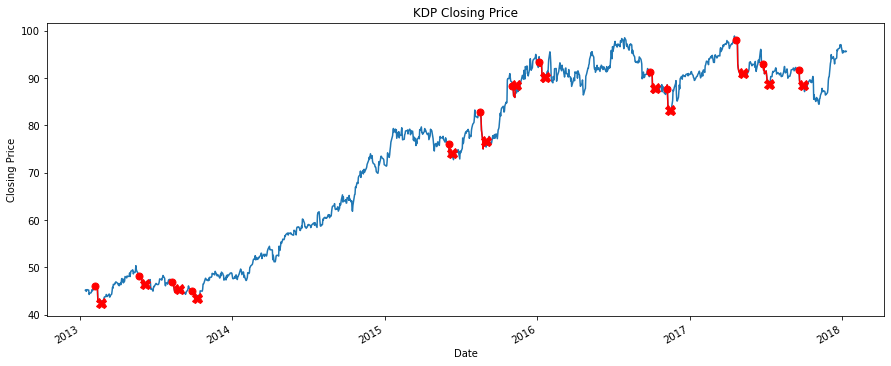

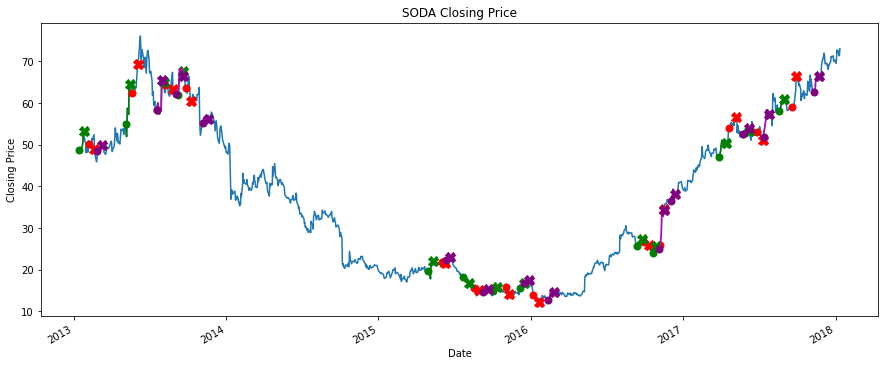

In [33]:
fig, ax = plt.subplots(figsize=(15, 6))
decreasing_asset_df['Close'].plot(
    title = f"{decreasing_asset_df.name} Closing Price",
    ax=ax
);


for i in range(len(list_f_up_trend_after)):

    decreasing_asset_df['Close'].iloc[list_i_down_trend[i] : list_f_down_trend[i]].plot(
        title = f"{decreasing_asset_df.name} Closing Price",
        ax=ax,
        color="r",
        label='Closing Price'

    );
    plt.xlabel("Date")
    plt.ylabel("Closing Price")
    plt.plot([decreasing_asset_df.index[list_i_down_trend[i]]], [decreasing_asset_df.iloc[list_i_down_trend[i]]['Close']], marker='o', markersize=7, color="red")
    plt.plot([decreasing_asset_df.index[list_f_down_trend[i]]], [decreasing_asset_df.iloc[list_f_down_trend[i]]['Close']], marker='X', markersize=10, color="red")

plt.show();


fig, ax = plt.subplots(figsize=(15, 6))
increasing_asset_df['Close'].plot(
    title = f"{increasing_asset_df.name} Closing Price",
    ax=ax,
    label='Closing Price'
);

for i in range(len(list_i_up_trend_before)):

    increasing_asset_df['Close'].iloc[list_i_up_trend_before[i] : list_f_up_trend_before[i]].plot(
        title = f"{increasing_asset_df.name} Closing Price",
        ax=ax,
        color="g"
    );
    plt.xlabel("Date")
    plt.ylabel("Closing Price")
    plt.plot([increasing_asset_df.index[list_i_down_trend[i]]], [increasing_asset_df.iloc[list_i_down_trend[i]]['Close']], marker='o', markersize=7, color="red")
    plt.plot([increasing_asset_df.index[list_f_down_trend[i]]], [increasing_asset_df.iloc[list_f_down_trend[i]]['Close']], marker='X', markersize=10, color="red")
    plt.plot([increasing_asset_df.index[list_i_up_trend_before[i]]], [increasing_asset_df.iloc[list_i_up_trend_before[i]]['Close']], marker='o', markersize=7, color="green")
    plt.plot([increasing_asset_df.index[list_f_up_trend_before[i]]], [increasing_asset_df.iloc[list_f_up_trend_before[i]]['Close']], marker='X', markersize=10, color="green")
    
for i in range(len(list_i_up_trend_after)):
    
    increasing_asset_df['Close'].iloc[list_i_up_trend_after[i] : list_f_up_trend_after[i]].plot(
        title = f"{increasing_asset_df.name} Closing Price",
        ax=ax,
        color="m"
    );

    plt.plot([increasing_asset_df.index[list_i_up_trend_after[i]]], [increasing_asset_df.iloc[list_i_up_trend_after[i]]['Close']], marker='o', markersize=7, color="purple")
    plt.plot([increasing_asset_df.index[list_f_up_trend_after[i]]], [increasing_asset_df.iloc[list_f_up_trend_after[i]]['Close']], marker='X', markersize=10, color="purple")
    
    
plt.show();

### 3) Take only times that shows also an increasing trend (above some threshold) and not just the biggest negative correaltion


In [16]:
list_i_up_trend_before_analysed = list_i_up_trend_before.copy()
list_f_up_trend_before_analysed = list_f_up_trend_before.copy()

list_i_down_trend_analysed = list_i_down_trend.copy()
list_f_down_trend_analysed = list_f_down_trend.copy()
list_i_down_trend_analysed2 = list_i_down_trend.copy()
list_f_down_trend_analysed2 = list_f_down_trend.copy()

list_i_up_trend_after_analysed = list_i_up_trend_after.copy()
list_f_up_trend_after_analysed = list_f_up_trend_after.copy()


In [17]:
def check_if_indeed_uprising(n,list_i_up_trend_before_analysed, list_f_up_trend_before_analysed, 
                             list_i_down_trend_analysed,list_f_down_trend_analysed,
                             asset, uprise_threshold= 0.005):
    

    for i in range(n):
        if (asset['Smoothed_Close'].iloc[list_f_up_trend_before_analysed[i]] - asset['Smoothed_Close'].iloc[list_i_up_trend_before_analysed[i]])/((list_f_up_trend_before_analysed[i]-list_i_up_trend_before_analysed[i]) * asset['Smoothed_Close'].iloc[list_i_up_trend_before_analysed[i]]) < uprise_threshold and i<len(list_i_up_trend_before_analysed):
            list_i_up_trend_before_analysed[i] = None
            list_f_up_trend_before_analysed[i] = None
            list_i_down_trend_analysed[i] = None
            list_f_down_trend_analysed[i] = None
    
   

    

In [18]:
n = len(list_i_up_trend_before)
check_if_indeed_uprising(n,list_i_up_trend_before_analysed, list_f_up_trend_before_analysed, 
                             list_i_down_trend_analysed,list_f_down_trend_analysed,
                             increasing_asset_df, uprise_threshold= 0.005)

n2 = len(list_i_up_trend_after)
check_if_indeed_uprising(n2,list_i_up_trend_after_analysed, list_f_up_trend_after_analysed, 
                             list_i_down_trend_analysed2,list_f_down_trend_analysed2,
                             increasing_asset_df, uprise_threshold= 0.005)

In [19]:
list_i_up_trend_before_analysed =  list(filter(None, list_i_up_trend_before_analysed))
list_f_up_trend_before_analysed =  list(filter(None, list_f_up_trend_before_analysed))
list_i_down_trend_analysed =  list(filter(None, list_i_down_trend_analysed))
list_f_down_trend_analysed =  list(filter(None, list_f_down_trend_analysed))


list_i_up_trend_after_analysed =  list(filter(None, list_i_up_trend_after_analysed))
list_f_up_trend_after_analysed =  list(filter(None, list_f_up_trend_after_analysed))
list_i_down_trend_analysed2 =  list(filter(None, list_i_down_trend_analysed2))
list_f_down_trend_analysed2 =  list(filter(None, list_f_down_trend_analysed2))

In [20]:
list_f_down_trend_analysed2

[98, 606, 662, 713, 759, 942, 968, 1130, 1187]

### We can plot only times that have both increasing and decreasing trends

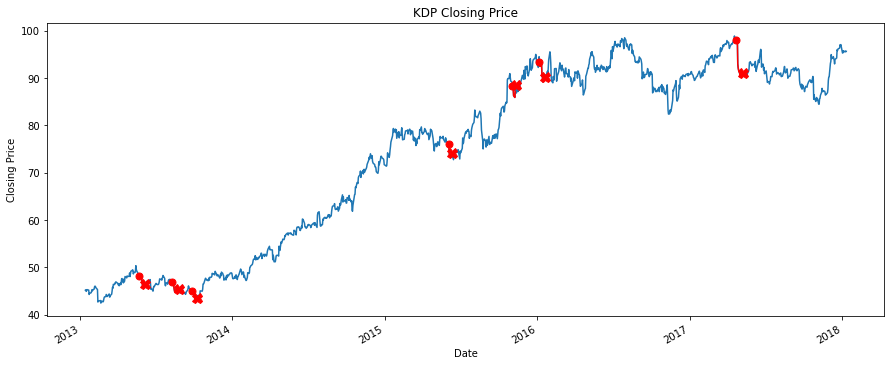

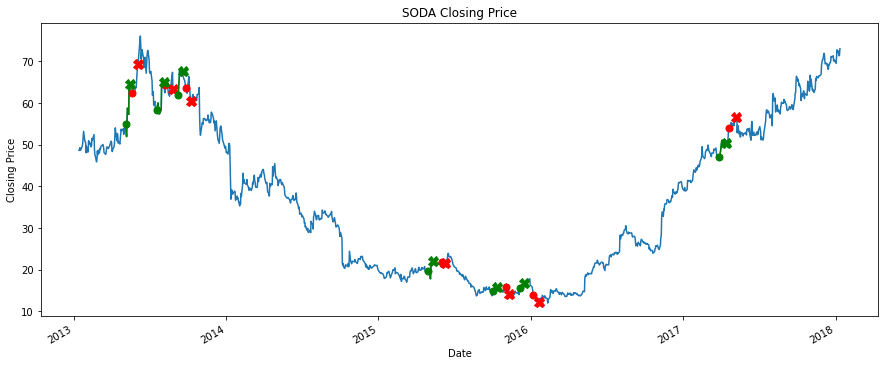

In [34]:
fig, ax = plt.subplots(figsize=(15, 6))
decreasing_asset_df['Close'].plot(
    title = f"{decreasing_asset_df.name} Closing Price",
    ax=ax
);

for i in range(len(list_i_up_trend_before_analysed)):

    decreasing_asset_df['Close'].iloc[list_i_down_trend_analysed[i] : list_f_down_trend_analysed[i]].plot(
        title = f"{decreasing_asset_df.name} Closing Price",
        ax=ax,
        color="r"
    );
    plt.xlabel("Date")
    plt.ylabel("Closing Price")
    plt.plot([decreasing_asset_df.index[list_i_down_trend_analysed[i]]], [decreasing_asset_df.iloc[list_i_down_trend_analysed[i]]['Close']], marker='o', markersize=7, color="red")
    plt.plot([decreasing_asset_df.index[list_f_down_trend_analysed[i]]], [decreasing_asset_df.iloc[list_f_down_trend_analysed[i]]['Close']], marker='X', markersize=10, color="red")

plt.show();


fig, ax = plt.subplots(figsize=(15, 6))
increasing_asset_df['Close'].plot(
    title = f"{increasing_asset_df.name} Closing Price",
    ax=ax
);

for i in range(len(list_i_up_trend_before_analysed)):

    increasing_asset_df['Close'].iloc[list_i_up_trend_before_analysed[i] : list_f_up_trend_before_analysed[i]].plot(
        title = f"{increasing_asset_df.name} Closing Price",
        ax=ax,
        color="g"
    );
    plt.xlabel("Date")
    plt.ylabel("Closing Price")
    plt.plot([increasing_asset_df.index[list_i_down_trend_analysed[i]]], [increasing_asset_df.iloc[list_i_down_trend_analysed[i]]['Close']], marker='o', markersize=7, color="red")
    plt.plot([increasing_asset_df.index[list_f_down_trend_analysed[i]]], [increasing_asset_df.iloc[list_f_down_trend_analysed[i]]['Close']], marker='X', markersize=10, color="red")
    plt.plot([increasing_asset_df.index[list_i_up_trend_before_analysed[i]]], [increasing_asset_df.iloc[list_i_up_trend_before_analysed[i]]['Close']], marker='o', markersize=7, color="green")
    plt.plot([increasing_asset_df.index[list_f_up_trend_before_analysed[i]]], [increasing_asset_df.iloc[list_f_up_trend_before_analysed[i]]['Close']], marker='X', markersize=10, color="green")

plt.show();

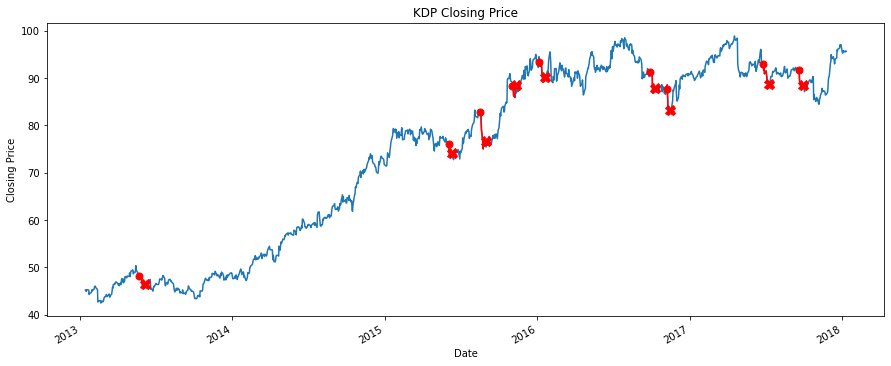

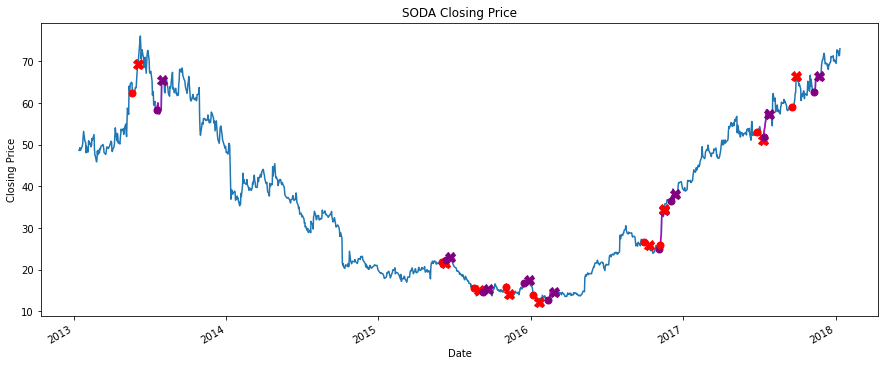

In [22]:
fig, ax = plt.subplots(figsize=(15, 6))
decreasing_asset_df['Close'].plot(
    title = f"{decreasing_asset_df.name} Closing Price",
    ax=ax
);

for i in range(len(list_i_up_trend_after_analysed)):

    decreasing_asset_df['Close'].iloc[list_i_down_trend_analysed2[i] : list_f_down_trend_analysed2[i]].plot(
        title = f"{decreasing_asset_df.name} Closing Price",
        ax=ax,
        color="r"
    );
    plt.xlabel("Date")
    plt.ylabel("Closing Price")
    plt.plot([decreasing_asset_df.index[list_i_down_trend_analysed2[i]]], [decreasing_asset_df.iloc[list_i_down_trend_analysed2[i]]['Close']], marker='o', markersize=7, color="red")
    plt.plot([decreasing_asset_df.index[list_f_down_trend_analysed2[i]]], [decreasing_asset_df.iloc[list_f_down_trend_analysed2[i]]['Close']], marker='X', markersize=10, color="red")

plt.show();


fig, ax = plt.subplots(figsize=(15, 6))
increasing_asset_df['Close'].plot(
    title = f"{increasing_asset_df.name} Closing Price",
    ax=ax
);

for i in range(len(list_i_up_trend_after_analysed)):

    increasing_asset_df['Close'].iloc[list_i_up_trend_after_analysed[i] : list_f_up_trend_after_analysed[i]].plot(
        title = f"{increasing_asset_df.name} Closing Price",
        ax=ax,
        color="m"
    );
    plt.xlabel("Date")
    plt.ylabel("Closing Price")
    plt.plot([increasing_asset_df.index[list_i_down_trend_analysed2[i]]], [increasing_asset_df.iloc[list_i_down_trend_analysed2[i]]['Close']], marker='o', markersize=7, color="red")
    plt.plot([increasing_asset_df.index[list_f_down_trend_analysed2[i]]], [increasing_asset_df.iloc[list_f_down_trend_analysed2[i]]['Close']], marker='X', markersize=10, color="red")
    plt.plot([increasing_asset_df.index[list_i_up_trend_after_analysed[i]]], [increasing_asset_df.iloc[list_i_up_trend_after_analysed[i]]['Close']], marker='o', markersize=7, color="purple")
    plt.plot([increasing_asset_df.index[list_f_up_trend_after_analysed[i]]], [increasing_asset_df.iloc[list_f_up_trend_after_analysed[i]]['Close']], marker='X', markersize=10, color="purple")

plt.show();

### 4) Plot the different timing and see if there is a trend


In [23]:
x_time_index_before=[]
x_bins_before = []
y_freq_before = []
for i in range(len(list_f_up_trend_before_analysed)):
    x_time_index_before.append((list_f_up_trend_before_analysed[i]+list_i_up_trend_before_analysed[i])/2)
    x_bins_before.append(increasing_asset_df.index[math.floor((list_f_up_trend_before_analysed[i]+list_i_up_trend_before_analysed[i])/2)])
    y_freq_before.append(list_i_down_trend_analysed[i]-list_i_up_trend_before_analysed[i])
    
    
x_time_index_after=[]
x_bins_after = []
y_freq_after = []
for i in range(len(list_f_up_trend_after_analysed)):
    x_time_index_after.append((list_f_up_trend_after_analysed[i]+list_i_up_trend_after_analysed[i])/2)
    x_bins_after.append(increasing_asset_df.index[math.floor((list_f_up_trend_after_analysed[i]+list_i_up_trend_after_analysed[i])/2)])
    y_freq_after.append(-list_i_down_trend_analysed2[i]+list_i_up_trend_after_analysed[i])

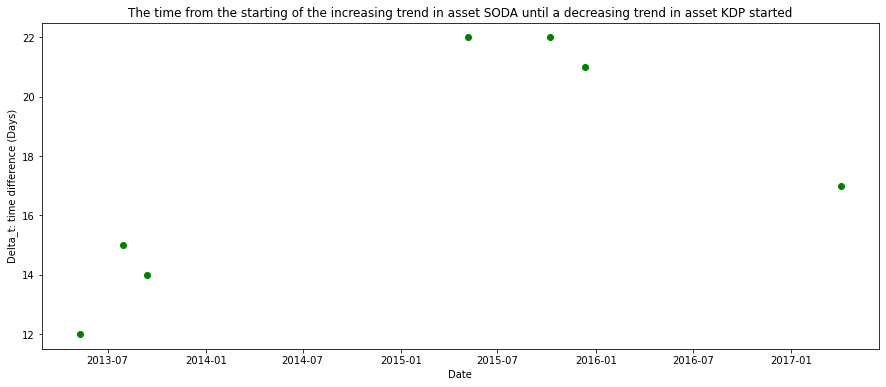

In [24]:
fig, ax = plt.subplots(figsize=(15, 6))

plt.scatter(x_bins_before,y_freq_before, color='g');
plt.xlabel("Date")
plt.ylabel("Delta_t: time difference (Days)")
plt.title(f"The time from the starting of the increasing trend in asset {increasing_asset_df.name} until a decreasing trend in asset {decreasing_asset_df.name} started")

plt.show();

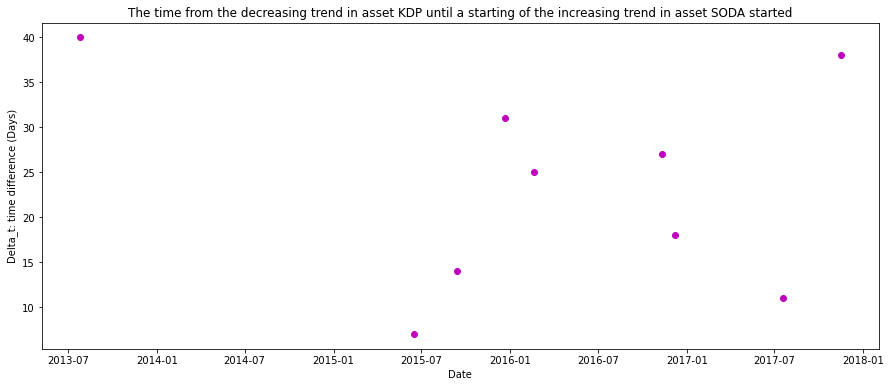

In [25]:
fig, ax = plt.subplots(figsize=(15, 6))

plt.scatter(x_bins_after,y_freq_after, color='m');
plt.xlabel("Date")
plt.ylabel("Delta_t: time difference (Days)")
plt.title(f"The time from the decreasing trend in asset {decreasing_asset_df.name} until a starting of the increasing trend in asset {increasing_asset_df.name} started")

plt.show();

We will try to fit the data into linear model

#### (a) Split the data to features and target

In [26]:
y_train_before = np.array(y_freq_before)
X_train_before = np.array(x_time_index_before)
#X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.3, random_state=2)

y_train_after = np.array(y_freq_after)
X_train_after = np.array(x_time_index_after)
#X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.3, random_state=2)

### (b) Build Model

#### Baseline

In [27]:
y_mean_before = y_train_before.mean()
y_pred_baseline_before = [y_mean_before] * len(y_train_before)
baseline_mae_before = mean_absolute_error(y_train_before, y_pred_baseline_before)
print(f"Mean Delta time for impact from increasing trend in {increasing_asset_df.name} to decreasing trend in {decreasing_asset_df.name}:", y_mean_before)
print("Baseline MAE:", baseline_mae_before)

Mean Delta time for impact from increasing trend in SODA to decreasing trend in KDP: 17.571428571428573
Baseline MAE: 3.5102040816326534


In [28]:
y_mean_after = y_train_after.mean()
y_pred_baseline_after = [y_mean_after] * len(y_train_after)
baseline_mae_after = mean_absolute_error(y_train_after, y_pred_baseline_after)
print(f"Mean Delta time for impact from increasing trend in {decreasing_asset_df.name} to decreasing trend in {increasing_asset_df.name}:", y_mean_after)
print("Baseline MAE:", baseline_mae_after)

Mean Delta time for impact from increasing trend in KDP to decreasing trend in SODA: 23.444444444444443
Baseline MAE: 9.728395061728396


#### Iterate

In [29]:
# Build Model
model_before = make_pipeline(
    OneHotEncoder(use_cat_names=True),# Transformer
    SimpleImputer(), # Transformer
    LinearRegression()    # Predictor
)

model_after = make_pipeline(
    OneHotEncoder(use_cat_names=True),# Transformer
    SimpleImputer(), # Transformer
    LinearRegression()    # Predictor
)

# Fit model
model_before.fit(X_train_before, y_train_before)
model_after.fit(X_train_after, y_train_after)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=[], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])


Delta_t (from incresing trend to decreasing trend) = 13.9425(days) + 0.0074 * (current date in days)


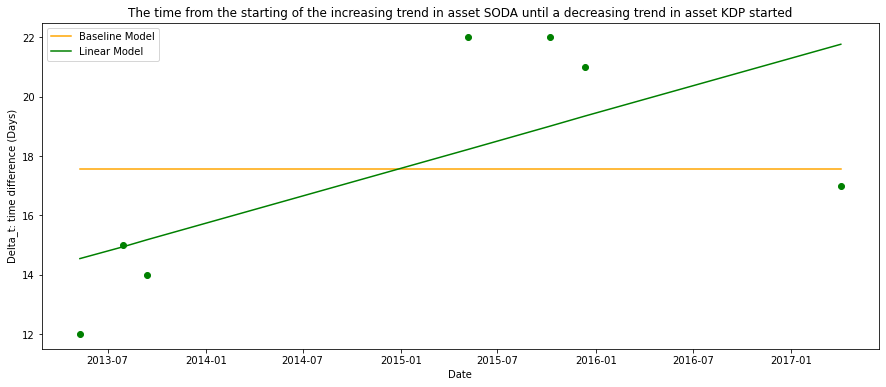

Baseline MAE: 3.5102040816326534
Training MAE for the model_before: 2.43
the model accuracy score is:  0.4434360153640923


In [30]:
intercept_before = model_before.named_steps["linearregression"].intercept_.round(4)
coefficients_before = model_before.named_steps["linearregression"].coef_.round(4)
y_pred_training_before = model_before.predict(X_train_before)
mae_training_before = mean_absolute_error(y_train_before, y_pred_training_before)

fig, ax = plt.subplots(figsize=(15, 6))

plt.plot(increasing_asset_df.index[list(X_train_before.astype(int))],y_pred_baseline_before, color = "orange", label = "Baseline Model")
plt.plot(increasing_asset_df.index[list(X_train_before.astype(int))], model_before.predict(X_train_before), color = "g" , label = "Linear Model")
plt.scatter(increasing_asset_df.index[list(X_train_before.astype(int))], y_train_before, color='g')
plt.xlabel("Date")
plt.ylabel("Delta_t: time difference (Days)")
plt.title(f"The time from the starting of the increasing trend in asset {increasing_asset_df.name} until a decreasing trend in asset {decreasing_asset_df.name} started")
plt.legend()
print()
print(f"Delta_t (from incresing trend to decreasing trend) = {intercept_before}(days) + {coefficients_before[0]} * (current date in days)")
plt.show();
print("Baseline MAE:", baseline_mae_before)
print("Training MAE for the model_before:", round(mae_training_before, 2))
print("the model accuracy score is: ",model_before.score(X_train_before, y_train_before))


In [31]:
y_pred_training_after = model_after.predict(X_train_after)
mae_training_after = mean_absolute_error(y_train_after, y_pred_training_after)



Delta_t (from decreasing trend to incresing trend) = 28.7707(days) + -0.0066 * (current date in days)


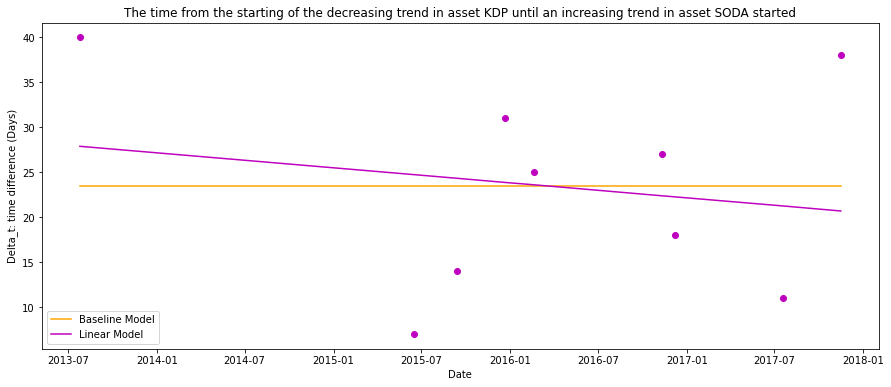

Baseline MAE: 9.728395061728396
Training MAE for the model_after: 9.46
the model accuracy score is:  0.03385195469714941


In [32]:
intercept_after = model_after.named_steps["linearregression"].intercept_.round(4)
coefficients_after = model_after.named_steps["linearregression"].coef_.round(4)


fig, ax = plt.subplots(figsize=(15, 6))

plt.plot(increasing_asset_df.index[list(X_train_after.astype(int))],y_pred_baseline_after, color = "orange", label = "Baseline Model")
plt.plot(increasing_asset_df.index[list(X_train_after.astype(int))], model_after.predict(X_train_after), color = "m" , label = "Linear Model")
plt.scatter(increasing_asset_df.index[list(X_train_after.astype(int))], y_train_after, color='m')
plt.xlabel("Date")
plt.ylabel("Delta_t: time difference (Days)")
plt.title(f"The time from the starting of the decreasing trend in asset {decreasing_asset_df.name} until an increasing trend in asset {increasing_asset_df.name} started")
plt.legend()
print()
print(f"Delta_t (from decreasing trend to incresing trend) = {intercept_after}(days) + {coefficients_after[0]} * (current date in days)")
plt.show();
print("Baseline MAE:", baseline_mae_after)
print("Training MAE for the model_after:", round(mae_training_after, 2))
print("the model accuracy score is: ",model_after.score(X_train_after, y_train_after))